In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# plyaer data load 및 정리(프로필)
player_df = pd.read_csv('./data/new/players_all.csv')
player_df = player_df.rename(columns={'Unnamed: 0':'Id'}).drop(['Id'], axis=1)

# 1xbet data load 및 정리(스텟)
xbet_df = pd.read_csv('./data/new/1xbet_all.csv')
xbet_df = xbet_df.drop(['Team','Age','Position'], axis=1).rename(columns={'Drb_x':'Drb_Off', 'Drb_y':'Drb_Def'})

# understat data load 및 정리(스텟)
understat_df = pd.read_csv('./data/new/understat_all.csv')
understat_df = understat_df.drop(['No','Team'], axis=1)

# capology load(연봉)
capology_df = pd.read_csv('./data/new/capology_all.csv')

# 프로필 + 연봉
eda_df = player_df.merge(capology_df[['Weekly Salary','Base Salary','ADJ Salary','Name', 'year']],
                         how='left', left_on=['Name', 'year'], right_on=['Name', 'year'])
eda_df = eda_df[~eda_df.duplicated(['year', 'Name'], keep='first')] # 중복 제거
# 프로필 + 연봉 + 스텟(understat)
eda_df = eda_df.merge(understat_df, how='left', left_on=['Name', 'year'], right_on=['Name', 'year'])
# 프로필 + 연봉 + 스텟(understat) + 스텟(1xbet)
eda_df = eda_df.merge(
    xbet_df[[
        'Name', 'year', 'SpG', 'KeyP', 'Drb_Off', 'Fouled', 'Off',
        'Disp', 'UnsTch', 'Rating', 'Tackles', 'Inter','Fouls',
        'Offsides', 'Clear', 'Drb_Def', 'Blocks', 'AvgP', 'PS%']],
    how='left',
    left_on=['Name', 'year'],
    right_on=['Name', 'year']
)

In [2]:
eda_df = eda_df.dropna()
round(eda_df.describe(), 2)

,Player Id,Birth Year,Age,year,Weekly Salary,Base Salary,ADJ Salary,Apps,Min,G,...,Rating,Tackles,Inter,Fouls,Offsides,Clear,Drb_Def,Blocks,AvgP,PS%
count,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,...,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00,4588.00
mean,129453.85,1992.02,25.91,2017.93,53921.12,2803898.52,3076834.48,20.58,1466.58,1.96,...,6.65,1.12,0.78,0.70,0.13,1.53,0.61,0.22,29.00,76.91
std,119957.91,4.93,4.21,2.60,52782.05,2744666.44,2942732.53,11.49,1032.21,3.52,...,0.36,0.84,0.70,0.46,0.23,1.75,0.48,0.29,16.44,12.42
min,17.00,1973.00,15.00,2014.00,0.00,0.00,0.00,1.00,1.00,0.00,...,4.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,31281.00,1989.00,23.00,2016.00,20000.00,1040000.00,1252784.00,11.00,532.50,0.00,...,6.40,0.50,0.18,0.38,0.00,0.33,0.25,0.00,17.00,72.73
50%,91387.00,1992.00,26.00,2018.00,40000.00,2080000.00,2301310.00,22.00,1390.00,1.00,...,6.65,1.00,0.65,0.68,0.00,0.86,0.53,0.11,27.29,79.32
75%,145392.00,1996.00,29.00,2020.00,70000.00,3640000.00,4071549.00,31.00,2326.25,2.00,...,6.88,1.63,1.20,1.00,0.15,2.09,0.88,0.33,38.44,84.32
max,470690.00,2005.00,41.00,2022.00,600000.00,31200000.00,33671679.00,38.00,3420.00,36.00,...,8.34,7.00,4.22,4.00,2.00,11.50,4.00,2.05,90.41,100.00


In [3]:
eda_df.columns

Index(['Player Id', 'Name', 'Birth Year', 'Age', 'Team', 'Position', 'year',
       'Weekly Salary', 'Base Salary', 'ADJ Salary', 'Apps', 'Min', 'G', 'NPG',
       'A', 'xG', 'NPxG', 'xA', 'xGChain', 'xGBuildup', 'xG90', 'NPxG90',
       'xA90', 'xG90+xA90', 'NPxG90+xA90', 'xGChain90', 'xGBuildup90', 'SpG',
       'KeyP', 'Drb_Off', 'Fouled', 'Off', 'Disp', 'UnsTch', 'Rating',
       'Tackles', 'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb_Def', 'Blocks',
       'AvgP', 'PS%'],
      dtype='object')

# 특정 선수와의 활동 비교
* sample  data 추출
    *  출전 시간(평균이상)
    * 출전 경기(평균이상)
    * 연봉(top100)
* Age Leveling 하기
* Age Leveling 별 평균치

In [4]:
min_mean = eda_df['Min'].mean()
min_mean

1466.5843504795118

In [5]:
apps_mean = eda_df.Apps.mean()
apps_mean

20.581952920662598

In [6]:
# 전체 연봉 정리
salary_list = eda_df[['Name', 'Weekly Salary']].groupby(['Name', 'Weekly Salary'])\
            .count().sort_values(by = 'Weekly Salary', ascending = False)
salary_list.head()

,
Name,Weekly Salary
Gareth Bale,600000.0
Cristiano Ronaldo,515000.0
Kevin De Bruyne,400000.0
David de Gea,375000.0
Erling Haaland,375000.0


In [7]:
# eda_df['Age Lev'] = eda_df['Age'].apply(lambda age: '<23' if age < 23 else '<25' if age <25 else '<27' if age<27 else '<30' if age<30 else '<33' if age<33 else '>33')
eda_df['Age Lev'] = eda_df['Age'].apply(lambda age: '<21' if age < 21 else '21' if age ==21 else '22' if age == 22
                                        else '23' if age == 23 else '24' if age == 24 else '25' if age == 25
                                        else '26' if age == 26 else '27' if age == 27 else '28' if age == 28
                                        else '29' if age == 29 else '30' if age == 30 else '31' if age == 31
                                        else '32' if age == 32 else '>32' )
eda_df['Age Lev'].unique()

array(['23', '25', '26', '27', '29', '30', '28', '22', '24', '31', '>32',
       '21', '<21', '32'], dtype=object)

In [8]:
position_min_means = eda_df[eda_df.Min > min_mean].groupby(['Position', 'Age Lev']).mean()

/var/folders/5r/gwhqhzlx7g5_xdjhhpzr42_h0000gn/T/ipykernel_69871/4094930306.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  position_min_means = eda_df[eda_df.Min > min_mean].groupby(['Position', 'Age Lev']).mean()


In [9]:
# '23', '25', '26', '27', '29', '30', '28', '22', '24', '31', '>32', '21', '<21', '32'
def get_age_lev(age):
    if age < 21:
        return '<21'
    elif age < 22:
        return '21'
    elif age < 23:
        return '22'
    elif age < 24:
        return '23'
    elif age < 25:
        return '24'
    elif age < 26:
        return '25'
    elif age < 27:
        return '26'
    elif age < 28:
        return '27'
    elif age < 29:
        return '28'
    elif age < 30:
        return '29'
    elif age < 31:
        return '30'
    elif age < 32:
        return '31'
    elif age < 33:
        return '32'
    else:
        return '>32'    

## 각 포지션 별 특정 대표 지표 정하기

### 공격수 G, xG, A, xA, NPG, Drb_Off
### 미드필더 G, xG, A, xA, xGBuildup, KeyP, Drb_Off, AvgP, PS%, Inter, Tackles, Clear, Blocks
### 수비수 G, xG, A, xA, xGBuildup, AvgP, PS%, Tackles, Inter, Clear, Blocks
### 모든 지표는 동나이대 동표지션과 비교해하는게 좋을 것 같습니다.

In [10]:
# ['year', 'Name', 'Age', 'Team', 'Position', 'Weekly Salary',
#        'Base Salary', 'ADJ Salary', 'Apps', 'Min', 'G', 'NPG', 'A', 'xG',
#        'NPxG', 'xA', 'xGChain', 'xGBuildup', 'xG90', 'NPxG90', 'xA90',
#        'xG90+xA90', 'NPxG90+xA90', 'xGChain90', 'xGBuildup90', 'SpG', 'KeyP',
#        'Drb_Off', 'Fouled', 'Off', 'Disp', 'UnsTch', 'Rating', 'Tackles',
#        'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb_Def', 'Blocks', 'AvgP',
#        'PS%']

In [11]:
eda_df[eda_df.Name.str.contains('Kante')]

,Player Id,Name,Birth Year,Age,Team,Position,year,Weekly Salary,Base Salary,ADJ Salary,...,Tackles,Inter,Fouls,Offsides,Clear,Drb_Def,Blocks,AvgP,PS%,Age Lev
536,114075,N'Golo Kante,1991,24,Leicester,Midfielder,2015,40000.0,2080000.0,2480554.0,...,4.729730,4.216216,1.162162,0.027027,1.540541,1.567568,0.297297,39.162162,81.642512,24
1122,114075,N'Golo Kante,1991,25,Chelsea,Midfielder,2016,150000.0,7800000.0,9070088.0,...,3.628571,2.342857,1.514286,0.057143,1.171429,1.314286,0.114286,60.628571,88.784166,25
1639,114075,N'Golo Kante,1991,26,Chelsea,Midfielder,2017,150000.0,7800000.0,8866787.0,...,3.323529,2.500000,1.205882,0.000000,0.764706,1.735294,0.117647,63.264706,89.260809,26
2221,114075,N'Golo Kante,1991,27,Chelsea,Midfielder,2018,290000.0,15080000.0,16849592.0,...,2.083333,1.222222,0.972222,0.000000,0.722222,1.222222,0.166667,56.166667,87.883284,27
2716,114075,N'Golo Kante,1991,28,Chelsea,Midfielder,2019,290000.0,15080000.0,16684501.0,...,2.000000,2.000000,2.045455,0.000000,1.409091,0.863636,0.227273,51.545455,84.920635,28
3253,114075,N'Golo Kante,1991,29,Chelsea,Midfielder,2020,290000.0,15080000.0,16274645.0,...,2.633333,1.966667,1.200000,0.000000,0.866667,0.966667,0.133333,50.966667,86.461740,29
3720,114075,N'Golo Kante,1991,30,Chelsea,Midfielder,2021,290000.0,15080000.0,15080000.0,...,2.269231,1.192308,0.846154,0.038462,0.307692,0.576923,0.076923,49.692308,86.687307,30
4266,114075,N'Golo Kante,1991,31,Chelsea,Midfielder,2022,290000.0,15080000.0,15080000.0,...,2.285714,0.857143,0.714286,0.000000,0.285714,0.571429,0.000000,46.428571,82.461538,31


In [12]:
player_name = "Harry Kane"

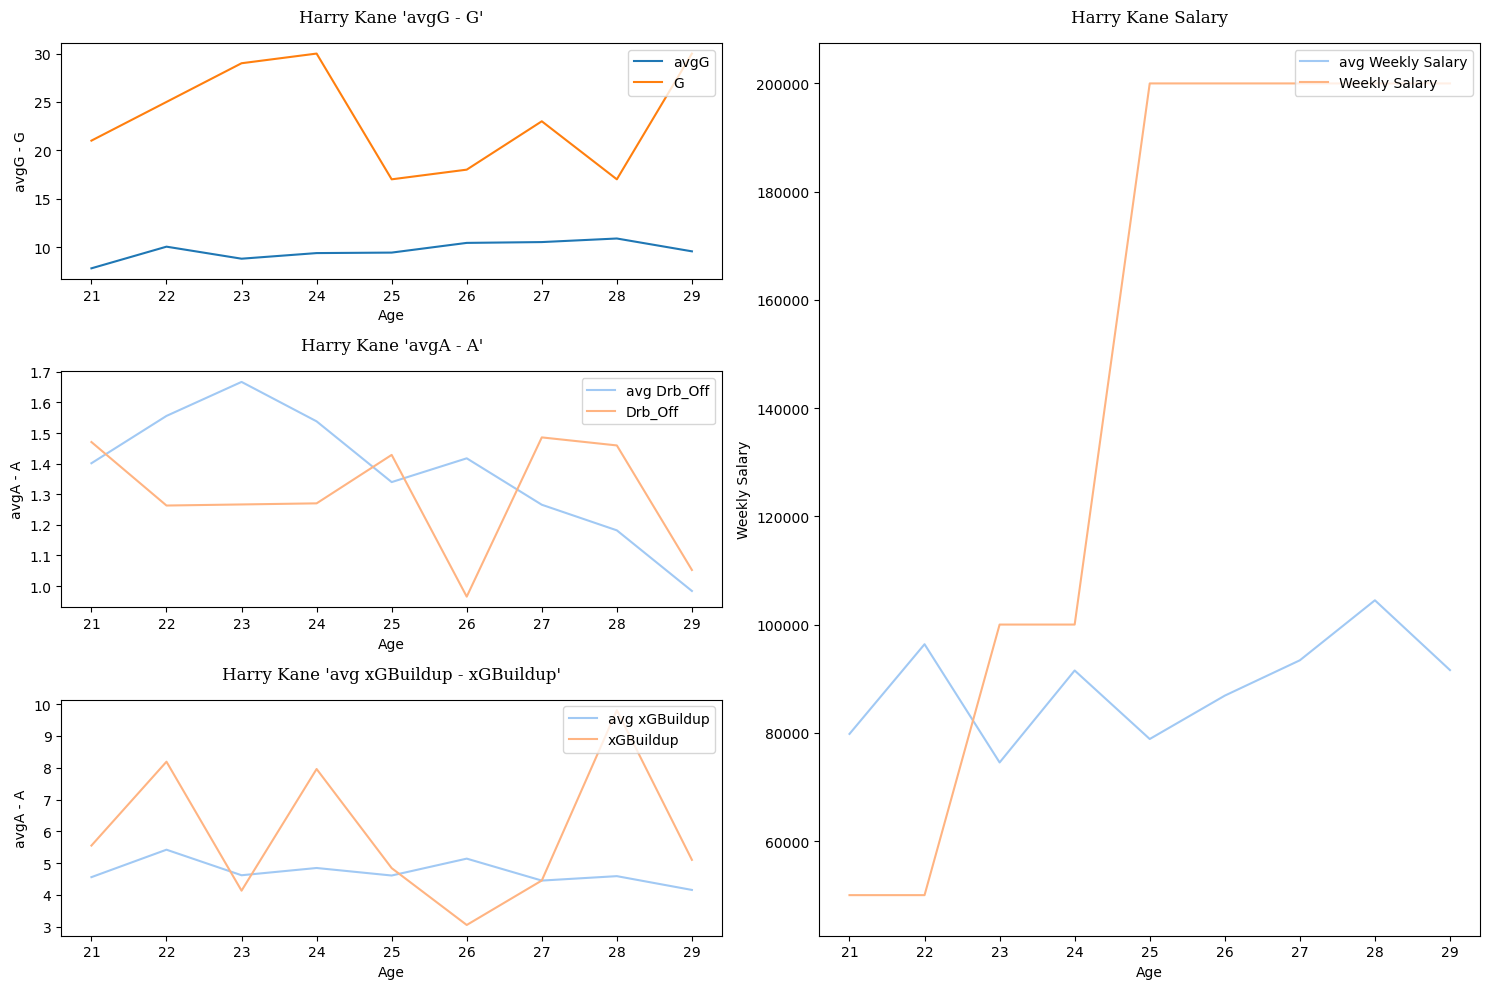

In [13]:
# 특정 선수 지표와 해당 나이대 지표 비교
# player_name = "Son Heung-Min"
one_player = eda_df[eda_df['Name'] == player_name]
position = one_player['Position'].unique()[0]

# 해당 포지션의 평균 값들만 가져옴
position_min_means.loc[position]

# 나이 범위에 맞추어 평균 값 데이터 만들기
means_list = [['Age', 'Age Lev', 'G', 'A', 'xGBuildup', 'Weekly Salary', 'Drb_Off']]
for age in one_player['Age'].unique():
    age_lev = get_age_lev(age)
    temp = list(position_min_means.loc[(position, age_lev)].loc[['G', 'A', 'xGBuildup', 'Weekly Salary', 'Drb_Off']])
    means_list.append([age, age_lev] + temp)
means_df = pd.DataFrame(means_list[1:], columns = means_list[0])

plt.figure(figsize = (15, 10))

# avgG - G
plt.subplot(3, 2, 1)
sns.set_palette('pastel')
plt.title(f'{player_name} \'avgG - G\'', pad = 15, fontfamily = 'serif')
plt.ylabel('avgG - G')

plt.xticks(one_player['Age'].unique())
sns.lineplot(data = means_df, x = 'Age', y = 'G', label = 'avgG')
sns.lineplot(data = one_player, x = 'Age', y = 'G', label = 'G')
plt.legend(loc = 'upper right')

# avgA - A
plt.subplot(3, 2, 3)
sns.set_palette('pastel')
plt.title(f'{player_name} \'avgA - A\'', pad = 15, fontfamily = 'serif')
plt.ylabel('avgA - A')

plt.xticks(one_player['Age'].unique())
sns.lineplot(data = means_df, x = 'Age', y = 'Drb_Off', label = 'avg Drb_Off')
sns.lineplot(data = one_player, x = 'Age', y = 'Drb_Off', label = 'Drb_Off')
plt.legend(loc = 'upper right')

# avg xGBuildup - xGBuildup
plt.subplot(3, 2, 5)
sns.set_palette('pastel')
plt.title(f'{player_name} \'avg xGBuildup - xGBuildup\'', pad = 15, fontfamily = 'serif')
plt.ylabel('avgA - A')

plt.xticks(one_player['Age'].unique())
sns.lineplot(data = means_df, x = 'Age', y = 'xGBuildup', label = 'avg xGBuildup')
sns.lineplot(data = one_player, x = 'Age', y = 'xGBuildup', label = 'xGBuildup')
plt.legend(loc = 'upper right')


# Salary
plt.subplot(1, 2, 2)
plt.title(f'{player_name} Salary', pad = 15, fontfamily = 'serif')

plt.xticks(one_player['Age'].unique())
sns.lineplot(data = means_df, x = 'Age', y = 'Weekly Salary', label = 'avg Weekly Salary')
sns.lineplot(data = one_player, x = 'Age', y = 'Weekly Salary', label = 'Weekly Salary')
plt.legend(loc = 'upper right')

plt.tight_layout()
plt.show()

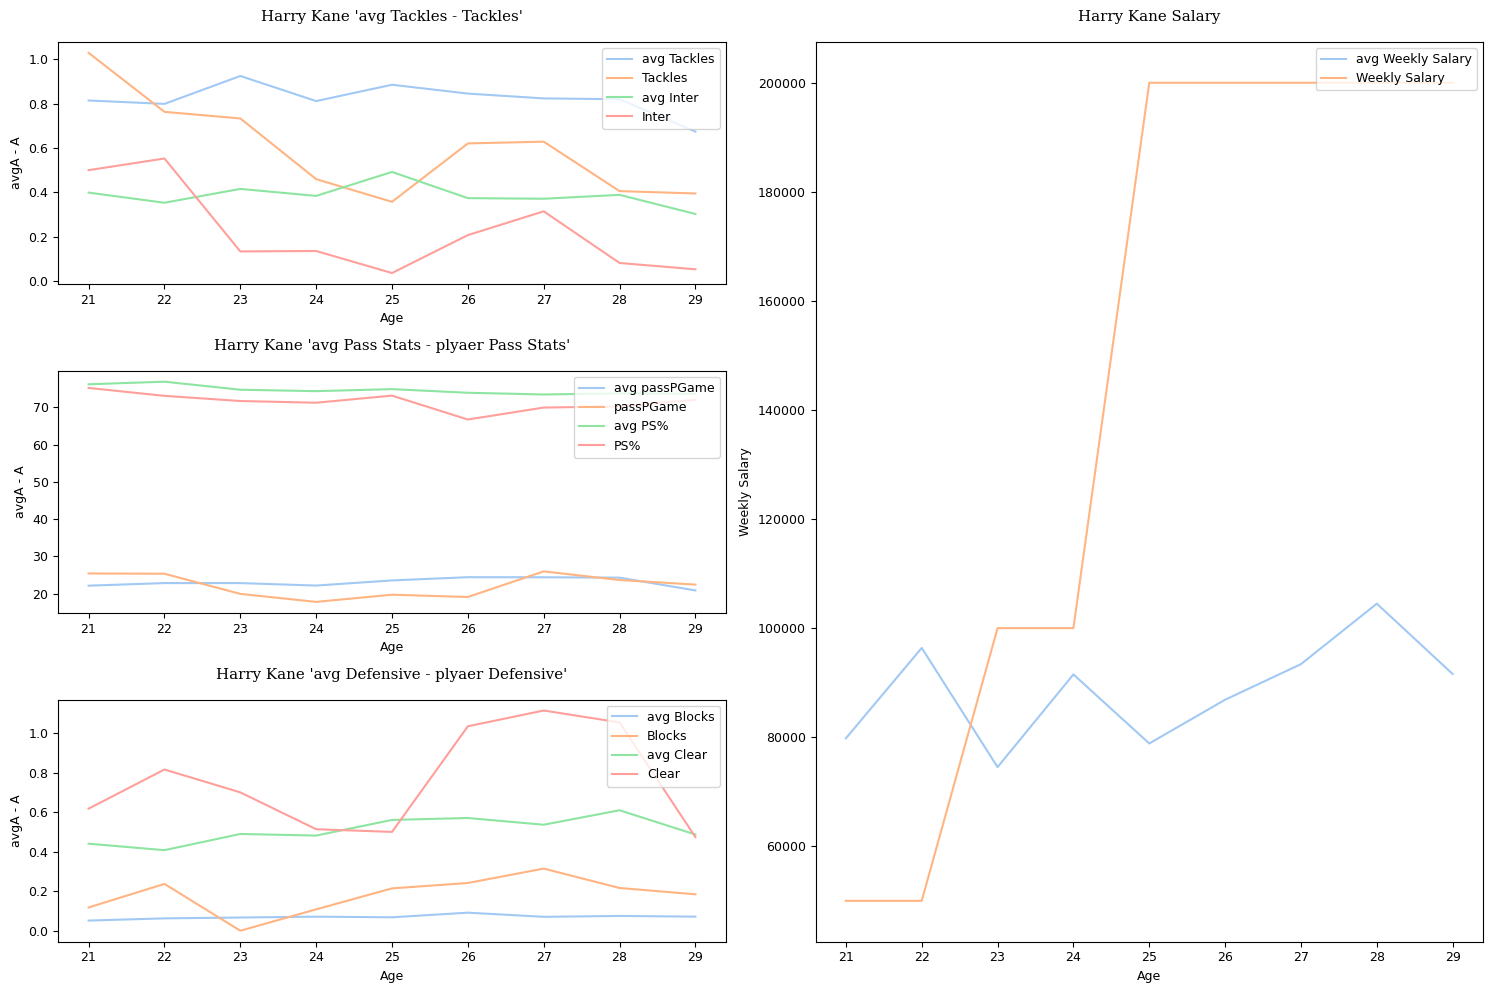

In [14]:
# 특정 선수 지표와 해당 나이대 지표 비교
# player_name = "Virgil van Dijk"
one_player = eda_df[eda_df['Name'] == player_name]
position = one_player['Position'].unique()[0]

# 해당 포지션의 평균 값들만 가져옴
position_min_means.loc[position]

# 나이 범위에 맞추어 평균 값 데이터 만들기
means_list = [['Age', 'Age Lev', 'xGBuildup', 'Weekly Salary', 'Tackles',
                'Inter', 'Fouls','Drb_Def', 'Blocks','Clear', 'AvgP','PS%']]
for age in one_player['Age'].unique():
    age_lev = get_age_lev(age)
    temp = list(position_min_means.loc[(position, age_lev)].loc[['xGBuildup', 'Weekly Salary', 'Tackles',
                                                                 'Inter', 'Fouls','Drb_Def', 'Blocks','Clear', 
                                                                 'AvgP','PS%']])
    means_list.append([age, age_lev] + temp)
means_df = pd.DataFrame(means_list[1:], columns = means_list[0])

plt.figure(figsize = (15, 10))
plt.rc('font', size= 9)


# avg xGBuildup - xGBuildup
# tackle
plt.subplot(3, 2, 1)
sns.set_palette('pastel')
plt.title(f'{player_name} \'avg Tackles - Tackles\'', pad = 15, fontfamily = 'serif')
plt.ylabel('avgA - A')

plt.xticks(one_player['Age'].unique())
sns.lineplot(data = means_df, x = 'Age', y = 'Tackles', label = 'avg Tackles')
sns.lineplot(data = one_player, x = 'Age', y = 'Tackles', label = 'Tackles')
sns.lineplot(data = means_df, x = 'Age', y = 'Inter', label = 'avg Inter')
sns.lineplot(data = one_player, x = 'Age', y = 'Inter', label = 'Inter')
plt.legend(loc = 'upper right')

# avg pass stat - stat
plt.subplot(3, 2, 3)
sns.set_palette('pastel')
plt.title(f'{player_name} \'avg Pass Stats - plyaer Pass Stats\'', pad = 15, fontfamily = 'serif')
plt.ylabel('avgA - A')

plt.xticks(one_player['Age'].unique())
sns.lineplot(data = means_df, x = 'Age', y = 'AvgP', label = 'avg passPGame')
sns.lineplot(data = one_player, x = 'Age', y = 'AvgP', label = 'passPGame')
sns.lineplot(data = means_df, x = 'Age', y = 'PS%', label = 'avg PS%')
sns.lineplot(data = one_player, x = 'Age', y = 'PS%', label = 'PS%')
plt.legend(loc = 'upper right')

# avg Defensive stat - stat
plt.subplot(3, 2, 5)
sns.set_palette('pastel')
plt.title(f'{player_name} \'avg Defensive - plyaer Defensive\'', pad = 15, fontfamily = 'serif')
plt.ylabel('avgA - A')

plt.xticks(one_player['Age'].unique())
# sns.lineplot(data = means_df, x = 'Age', y = 'Tackles', label = 'avg Tackles')
# sns.lineplot(data = one_player, x = 'Age', y = 'Tackles', label = 'Tackles')
sns.lineplot(data = means_df, x = 'Age', y = 'Blocks', label = 'avg Blocks')
sns.lineplot(data = one_player, x = 'Age', y = 'Blocks', label = 'Blocks')
sns.lineplot(data = means_df, x = 'Age', y = 'Clear', label = 'avg Clear')
sns.lineplot(data = one_player, x = 'Age', y = 'Clear', label = 'Clear')
plt.legend(loc = 'upper right')

# Salary
plt.subplot(1, 2, 2)
plt.title(f'{player_name} Salary', pad = 15, fontfamily = 'serif')

plt.xticks(one_player['Age'].unique())
sns.lineplot(data = means_df, x = 'Age', y = 'Weekly Salary', label = 'avg Weekly Salary')
sns.lineplot(data = one_player, x = 'Age', y = 'Weekly Salary', label = 'Weekly Salary')
plt.legend(loc = 'upper right')

plt.tight_layout()
plt.show()
# plt.savefig(f'{player_name}.png')